# Airdrops -- Exploratory Data Analysis

**[Johnnatan Messias](https://johnnatan-messias.github.io/), May 2025**.


In [ ]:
# Standard Library Imports
from utils_plot import percentiles
import os

# Third-Party Libraries
import polars as pl
from tqdm.notebook import tqdm

# Polars Configuration
pl.Config.set_float_precision(18)

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

In [3]:
protocols = ["ens", "dydx", "1inch", "gemstone", "arbitrum",
             "optimism", "uniswap", "arkham", "lido", "tornado"]

In [4]:
data_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "data"))

os.makedirs(data_dir, exist_ok=True)

In [5]:
# Loading dead/null addresses
dead_addresses = pl.read_csv(os.path.join(
    data_dir, "dead_addresses.csv"))['address']

In [6]:
decimals = 1e18

# Loading data


In [7]:
from pathlib import Path


def load_dataset(protocols):
    # Define base data directory
    base_path = Path(data_dir)

    # Load datasets using dictionary comprehension
    return {
        protocol: {
            'transfer': pl.scan_parquet(base_path / f"{protocol}_transfer.parquet"),
            'claim': pl.scan_parquet(base_path / f"{protocol}_claim.parquet")
        }
        for protocol in tqdm(protocols)
    }

In [8]:
# Load the dataset once
dfs = load_dataset(protocols)

# Define protocols with 'to' as receiver in claim
to_receiver_protocols = {"1inch", "uniswap", "lido", "tornado", "optimism"}

for protocol, data in dfs.items():
    print(protocol)

    # Rename for 'transfer'
    data['transfer'] = data['transfer'].rename(
        {"from": "sender", "to": "receiver"})

    # Determine claim renaming based on protocol
    claim_rename = {"to": "receiver"} if protocol in to_receiver_protocols else {
        "account": "receiver"}

    # Apply renaming for 'claim'
    data['claim'] = data['claim'].rename(claim_rename)

  0%|          | 0/10 [00:00<?, ?it/s]

ens
dydx
1inch
gemstone
arbitrum
optimism
uniswap
arkham
lido
tornado


In [9]:
# Loading exchange addresses
# Define data paths
cex_path = os.path.join(data_dir, "cex_addresses.csv")
dex_path = os.path.join(data_dir, "dex_addresses.csv")

# Load data
exchange_cex_addresses_df = pl.read_csv(cex_path)
exchange_dex_addresses_df = pl.read_csv(dex_path)

# Union set of the exchanges
exchange_addresses_set = set(exchange_cex_addresses_df['address'].to_list(
) + exchange_dex_addresses_df['address'].to_list())

# Output the number of addresses
print(
    f"There are {exchange_cex_addresses_df['address'].unique().len()} CEX addresses and {exchange_dex_addresses_df['address'].unique().len()} DEX addresses.")

print(f"There are {len(exchange_addresses_set)} exchange addresses in total.")

# Adding fake exchange created during the Gemstone airdrop attack.
exchange_addresses_set.add('0x7aa1ed8fb5e820e38c86cf3dd0a9eb0169a149ad')

There are 3011 CEX addresses and 558 DEX addresses.
There are 3569 exchange addresses in total.


# Tokens sold at exchanges


In [10]:
def initialize_account(balances_dict, address):
    if address not in balances_dict:
        balances_dict[address] = {
            'current': 0, 'history': [], 'n_sender': 0, 'n_receiver': 0
        }


def update_balance_history(balances_dict, address, block_number, timestamp, balance_before, balance_after):
    balances_dict[address]['history'].append({
        'block_number': block_number,
        'timestamp': timestamp,
        'balance_before': balance_before,
        'balance_after': balance_after
    })


def compute_account_balances(transfer_df):
    balances_history_dict = {}
    # Collecting data lazily
    data = transfer_df.select([
        pl.col("sender"),
        pl.col("receiver"),
        pl.col("amount"),
        pl.col("blockNumber"),
        pl.col("timestamp")
    ]).collect()
    for row in tqdm(data.iter_rows(named=True), desc='Loading balances', total=len(data)):
        sender, receiver = row['sender'], row['receiver']
        balance = float(row['amount'])
        block_number, timestamp = row['blockNumber'], row['timestamp']

        # Initialize sender and receiver accounts
        initialize_account(balances_history_dict, sender)
        initialize_account(balances_history_dict, receiver)

        # Update balance history
        sender_before = balances_history_dict[sender]['current']
        receiver_before = balances_history_dict[receiver]['current']
        update_balance_history(balances_history_dict, sender, block_number,
                               timestamp, sender_before, sender_before - balance)
        update_balance_history(balances_history_dict, receiver, block_number,
                               timestamp, receiver_before, receiver_before + balance)

        # Update transaction counts
        # update_transaction_counts(balances_history_dict, sender, receiver)
        balances_history_dict[sender]['n_sender'] += 1
        balances_history_dict[receiver]['n_receiver'] += 1

        # Update current balances
        balances_history_dict[sender]['current'] -= balance
        balances_history_dict[receiver]['current'] += balance

    print(f"Total unique addresses: {len(balances_history_dict)}")
    return balances_history_dict

In [11]:
balances = dict()
for protocol in protocols:
    print(protocol)
    balances[protocol] = compute_account_balances(dfs[protocol]['transfer'])

ens


Loading balances:   0%|          | 0/998619 [00:00<?, ?it/s]

Total unique addresses: 238936
dydx


Loading balances:   0%|          | 0/747372 [00:00<?, ?it/s]

Total unique addresses: 182159
1inch


Loading balances:   0%|          | 0/1782998 [00:00<?, ?it/s]

Total unique addresses: 371378
gemstone


Loading balances:   0%|          | 0/261896 [00:00<?, ?it/s]

Total unique addresses: 20020
arbitrum


Loading balances:   0%|          | 0/47330340 [00:00<?, ?it/s]

Total unique addresses: 2800826
optimism


Loading balances:   0%|          | 0/43990557 [00:00<?, ?it/s]

Total unique addresses: 1994406
uniswap


Loading balances:   0%|          | 0/4872925 [00:00<?, ?it/s]

Total unique addresses: 1358791
arkham


Loading balances:   0%|          | 0/283775 [00:00<?, ?it/s]

Total unique addresses: 129695
lido


Loading balances:   0%|          | 0/1107586 [00:00<?, ?it/s]

Total unique addresses: 127786
tornado


Loading balances:   0%|          | 0/278455 [00:00<?, ?it/s]

Total unique addresses: 34968


In [12]:
exchange_balances = dict()
for protocol in tqdm(protocols, desc='Adding exchange balances'):
    balance = 0
    for exchange in exchange_addresses_set:
        if exchange in balances[protocol]:
            balance += balances[protocol][exchange]['current']
    exchange_balances[protocol] = balance
for exchange_balance in exchange_balances:
    print("The exchange balance for {} is {}".format(
        exchange_balance, exchange_balances[exchange_balance]))

Adding exchange balances:   0%|          | 0/10 [00:00<?, ?it/s]

The exchange balance for ens is 10710927.815547844
The exchange balance for dydx is 116277337.90959203
The exchange balance for 1inch is 557717062.2673182
The exchange balance for gemstone is 291997156478789.5
The exchange balance for arbitrum is 852070646.5485425
The exchange balance for optimism is 242895481.68695223
The exchange balance for uniswap is 79325697.70988524
The exchange balance for arkham is 143835350.31371495
The exchange balance for lido is 155404705.4528674
The exchange balance for tornado is 669218.6397018762


In [13]:
for protocol in protocols:
    protocol_exchange_balance = exchange_balances[protocol]
    protocol_airdrop_supply = dfs[protocol]['claim'].select(
        pl.col('amount')).sum().collect().item()
    print(protocol, 100 *
          protocol_exchange_balance/protocol_airdrop_supply)

ens 54.55725354924501
dydx 69.41434878805683
1inch 666.7841259258995
gemstone 0.5794195062460137
arbitrum 77.970505119002
optimism 146.1007389776537
uniswap 57.884857489868445
arkham 489.3271375646676
lido 3913.4462938739816
tornado 133.84372794037523


In [14]:
exchange_balances

{'ens': 10710927.815547844,
 'dydx': 116277337.90959203,
 '1inch': 557717062.2673182,
 'gemstone': 291997156478789.5,
 'arbitrum': 852070646.5485425,
 'optimism': 242895481.68695223,
 'uniswap': 79325697.70988524,
 'arkham': 143835350.31371495,
 'lido': 155404705.4528674,
 'tornado': 669218.6397018762}

In [15]:
def compute_distribution_stats(protocol, dfs, exchange_addresses_set):
    # Extract unique claimants using lazy operations
    claimant_df = dfs[protocol]['claim'].select('receiver').unique().collect()

    # Filter and aggregate data using lazy operations
    data = (
        dfs[protocol]['transfer']
        .filter(
            (pl.col('sender').is_in(claimant_df['receiver'])) &
            (pl.col('receiver').is_in(exchange_addresses_set))
        )
        .sort(by=['blockNumber', 'transactionIndex', 'logIndex'])
    )

    # Compute balance using only Polars operations
    balance = (
        data
        .select(['sender', 'amount'])
        # Ensure each sender is counted once
        .unique(subset=['sender'], keep='first', maintain_order=True)
        .select(pl.col('amount').cast(pl.Float64)).sum()
        .collect()
        .item()
    )

    # Calculate the total claim amount using lazy evaluation
    total_claim_amount = dfs[protocol]['claim'].select(
        pl.col('amount').sum()).collect().item()

    # Calculate percentage balance
    percentage_balance = (balance / total_claim_amount) * \
        100 if total_claim_amount != 0 else 0

    # Output
    print(f"{protocol}: {percentage_balance:.2f}% | Balance: {balance} | Total Claimed: {total_claim_amount}")


for protocol in protocols:
    compute_distribution_stats(protocol, dfs, exchange_addresses_set)

ens: 46.74% | Balance: 9175886.608028274 | Total Claimed: 19632454.199476592
dydx: 13.56% | Balance: 22708853.8403148 | Total Claimed: 167511962.49729607
1inch: 58.67% | Balance: 49077174.96056065 | Total Claimed: 83642822.40415813
gemstone: 95.01% | Balance: 4.788090624878638e+16 | Total Claimed: 5.0394775e+16
arbitrum: 28.64% | Balance: 312937356.20131445 | Total Claimed: 1092811500.0
optimism: 48.21% | Balance: 80151352.8915 | Total Claimed: 166252055.5245812
uniswap: 43.69% | Balance: 59878693.30759989 | Total Claimed: 137040499.276982
arkham: 19.79% | Balance: 5818423.308377024 | Total Claimed: 29394517.342645075
lido: 65.75% | Balance: 2610834.1729569724 | Total Claimed: 3971044.797424059
tornado: 33.71% | Balance: 168571.8594565302 | Total Claimed: 500000.00000000006


In [106]:
import networkx as nx

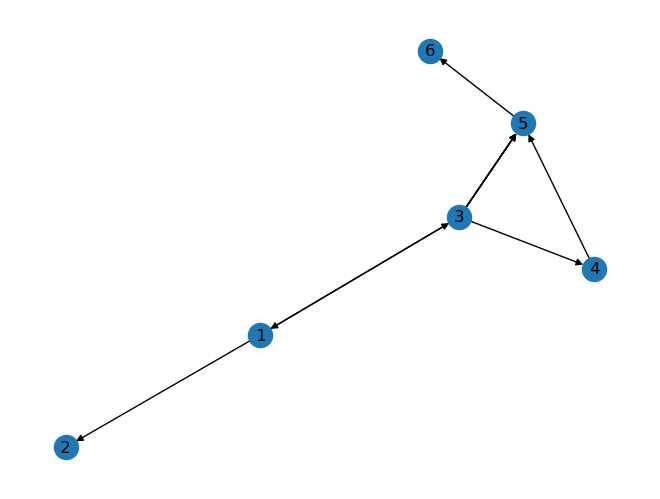

In [142]:
G = nx.MultiDiGraph()
G.add_edge(1, 2, timestamp=1)
G.add_edge(1, 3, timestamp=2)
G.add_edge(3, 1, timestamp=7)
G.add_edge(3, 4, timestamp=4)
G.add_edge(3, 5, timestamp=5)
G.add_edge(3, 5, timestamp=2)
G.add_edge(3, 5, timestamp=1)
G.add_edge(3, 5, timestamp=10)
G.add_edge(4, 5, timestamp=6)
G.add_edge(5, 6, timestamp=7)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)

In [143]:
sources = set([1, 2, 3])

In [144]:
set(nx.multi_source_dijkstra_path_length(G, sources, cutoff=1).keys())

{1, 2, 3, 4, 5}

In [145]:
nodes = set()
for source in sources:
    nodes.update(nx.multi_source_dijkstra_path_length(
        G, sources, cutoff=1).keys())
nodes

{1, 2, 3, 4, 5}

In [146]:
edges_to_include = [
    (u, v, k) for u, v, k, data in G.edges(keys=True, data=True)
    if 1 <= data.get('timestamp') <= 3
]
edges_to_include

[(1, 2, 0), (1, 3, 0), (3, 5, 1), (3, 5, 2)]

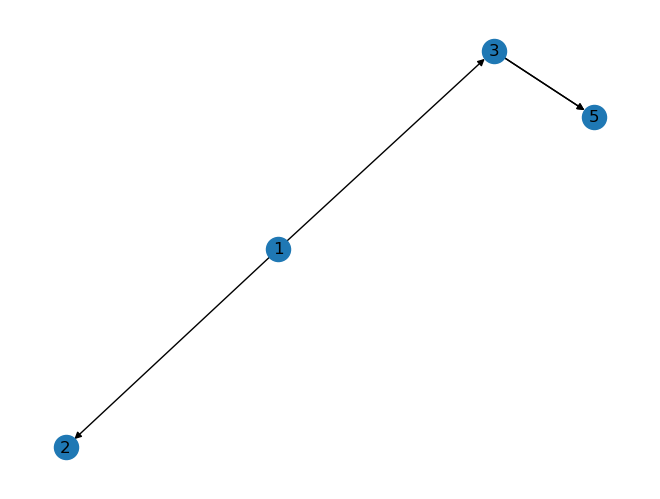

In [147]:
g = G.edge_subgraph(edges_to_include)
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True)